<a href="https://www.kaggle.com/code/batool01/notebookb02?scriptVersionId=232045717" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/kaggle/input/quality-prediction-in-a-mining-process/MiningProcess_Flotation_Plant_Database.csv')


In [3]:
# Check the first few rows
print("First 5 rows of the dataset:")
print(df.head())
print("\n")

First 5 rows of the dataset:
                  date % Iron Feed % Silica Feed Starch Flow Amina Flow  \
0  2017-03-10 01:00:00        55,2         16,98     3019,53    557,434   
1  2017-03-10 01:00:00        55,2         16,98     3024,41    563,965   
2  2017-03-10 01:00:00        55,2         16,98     3043,46    568,054   
3  2017-03-10 01:00:00        55,2         16,98     3047,36    568,665   
4  2017-03-10 01:00:00        55,2         16,98     3033,69    558,167   

  Ore Pulp Flow Ore Pulp pH Ore Pulp Density Flotation Column 01 Air Flow  \
0       395,713     10,0664             1,74                      249,214   
1       397,383     10,0672             1,74                      249,719   
2       399,668      10,068             1,74                      249,741   
3       397,939     10,0689             1,74                      249,917   
4       400,254     10,0697             1,74                      250,203   

  Flotation Column 02 Air Flow  ... Flotation Column 07 A

In [4]:
# Check data types and missing values
print("Data types and missing values:")
print(df.info())
print("\n")

Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date                          737453 non-null  object
 1   % Iron Feed                   737453 non-null  object
 2   % Silica Feed                 737453 non-null  object
 3   Starch Flow                   737453 non-null  object
 4   Amina Flow                    737453 non-null  object
 5   Ore Pulp Flow                 737453 non-null  object
 6   Ore Pulp pH                   737453 non-null  object
 7   Ore Pulp Density              737453 non-null  object
 8   Flotation Column 01 Air Flow  737453 non-null  object
 9   Flotation Column 02 Air Flow  737453 non-null  object
 10  Flotation Column 03 Air Flow  737453 non-null  object
 11  Flotation Column 04 Air Flow  737453 non-null  object
 12  Flotation Column 05 Air Flo

In [5]:
# Summary statistics
print("Summary statistics:")
print(df.describe())
print("\n")

Summary statistics:
                       date % Iron Feed % Silica Feed Starch Flow Amina Flow  \
count                737453      737453        737453      737453     737453   
unique                 4097         278           293      409317     319416   
top     2017-06-16 15:00:00       64,03          6,26      2562,5    534,668   
freq                    180      142560        142560         690        959   

       Ore Pulp Flow Ore Pulp pH Ore Pulp Density  \
count         737453      737453           737453   
unique        180189      131143           105805   
top          402,246     10,0591             1,75   
freq            1735        1509             3214   

       Flotation Column 01 Air Flow Flotation Column 02 Air Flow  ...  \
count                        737453                       737453  ...   
unique                        43675                        80442  ...   
top                         299,927                      255,322  ...   
freq                 

In [6]:
# Check for missing values
print("Missing values count:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])
print(f"Total missing values: {df.isnull().sum().sum()}")
print("\n")

Missing values count:
Series([], dtype: int64)
Total missing values: 0




In [7]:
# Fix data format issues - replace commas with dots and convert to float
for column in df.columns:
    if df[column].dtype == 'object':
        try:
            df[column] = df[column].str.replace(',', '.').astype(float)
        except:
            pass

In [8]:
# Identify target variable and fix its name if necessary
target_column = '% Silica Concentrate'
print(f"Target variable: {target_column}")
print(f"Target variable statistics: \n{df[target_column].describe()}")
print("\n")

Target variable: % Silica Concentrate
Target variable statistics: 
count    737453.000000
mean          2.326763
std           1.125554
min           0.600000
25%           1.440000
50%           2.000000
75%           3.010000
max           5.530000
Name: % Silica Concentrate, dtype: float64




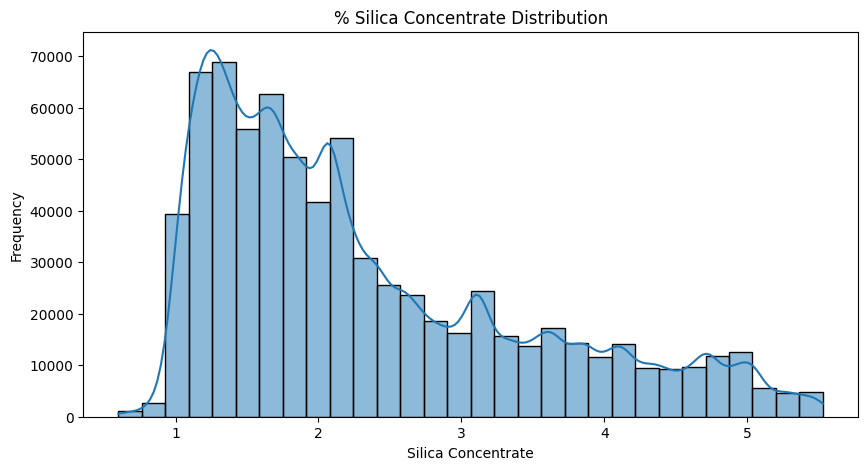

In [9]:
import seaborn as sns

# Histogram with KDE (Kernel Density Estimate)
plt.figure(figsize=(10,5))
sns.histplot(df['% Silica Concentrate'], bins=30, kde=True)
plt.title('% Silica Concentrate Distribution')
plt.xlabel('Silica Concentrate')
plt.ylabel('Frequency')
plt.show()

In [10]:
# Remove rows with missing values in the target column
print(f"Rows before cleaning target: {df.shape[0]}")
df = df.dropna(subset=[target_column])
print(f"Rows after cleaning target: {df.shape[0]}")

Rows before cleaning target: 737453
Rows after cleaning target: 737453


In [11]:
# For remaining columns, impute missing values with median
numeric_columns = df.select_dtypes(include=['number']).columns
for column in numeric_columns:
    if df[column].isnull().sum() > 0:
        median_value = df[column].median()
        df[column] = df[column].fillna(median_value)
        print(f"Imputed {df[column].isnull().sum()} values in {column} with median: {median_value}")

In [12]:
# Check for outliers in target variable using IQR method
Q1 = df[target_column].quantile(0.25)
Q3 = df[target_column].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df[target_column] < lower_bound) | (df[target_column] > upper_bound)]
print(f"Number of outliers in target variable: {len(outliers)}")
print(f"Outlier boundaries: Lower = {lower_bound}, Upper = {upper_bound}")

Number of outliers in target variable: 4757
Outlier boundaries: Lower = -0.9149999999999996, Upper = 5.364999999999999


In [13]:
# Remove extreme outliers (optional)
df = df[(df[target_column] >= lower_bound) & (df[target_column] <= upper_bound)]
print(f"Dataset shape after removing outliers: {df.shape}")


Dataset shape after removing outliers: (732696, 24)


In [14]:
# Calculate correlations with target variable, excluding non-numeric columns
correlations = df.select_dtypes(include=['number']).corr()[target_column].sort_values(ascending=False)
print("Top correlations with % Silica Concentrate:")
print(correlations.head(10))
print("\nBottom correlations with % Silica Concentrate:")
print(correlations.tail(10))
print("\n")

Top correlations with % Silica Concentrate:
% Silica Concentrate            1.000000
Amina Flow                      0.149317
% Silica Feed                   0.067996
Ore Pulp Density                0.042645
Flotation Column 02 Level       0.035988
Flotation Column 01 Level       0.017362
Flotation Column 03 Level       0.016445
Ore Pulp Flow                   0.010447
Flotation Column 05 Air Flow   -0.007698
Flotation Column 04 Air Flow   -0.013913
Name: % Silica Concentrate, dtype: float64

Bottom correlations with % Silica Concentrate:
Flotation Column 07 Air Flow   -0.081059
Flotation Column 06 Level      -0.095303
Flotation Column 07 Level      -0.135982
Flotation Column 04 Level      -0.145190
Ore Pulp pH                    -0.158049
Flotation Column 05 Level      -0.164029
Flotation Column 02 Air Flow   -0.175096
Flotation Column 01 Air Flow   -0.226994
Flotation Column 03 Air Flow   -0.227185
% Iron Concentrate             -0.798295
Name: % Silica Concentrate, dtype: float64




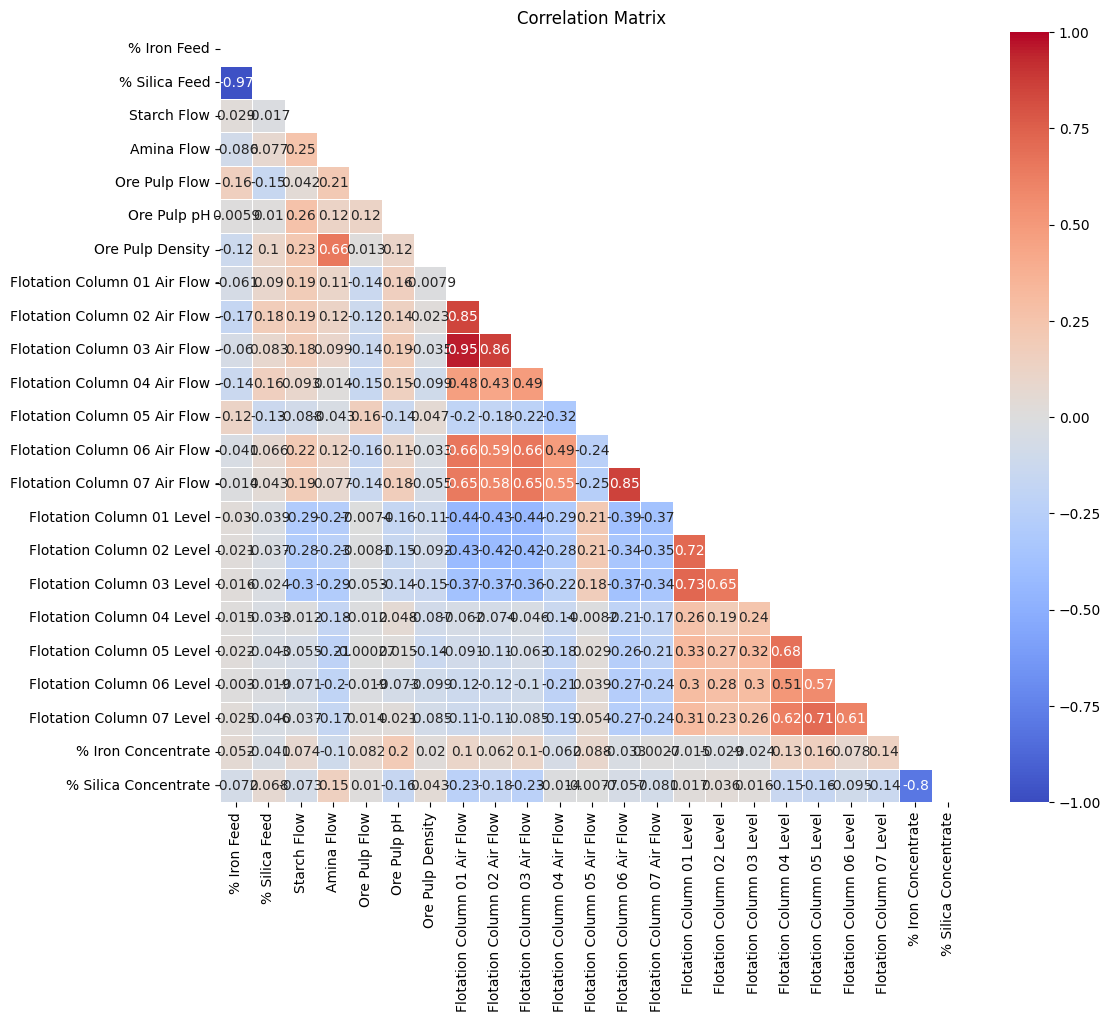

In [15]:
# Convert 'date' column to datetime if not already
df['date'] = pd.to_datetime(df['date'])

# Extract only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Optional: create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5, vmax=1, vmin=-1)
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.show()


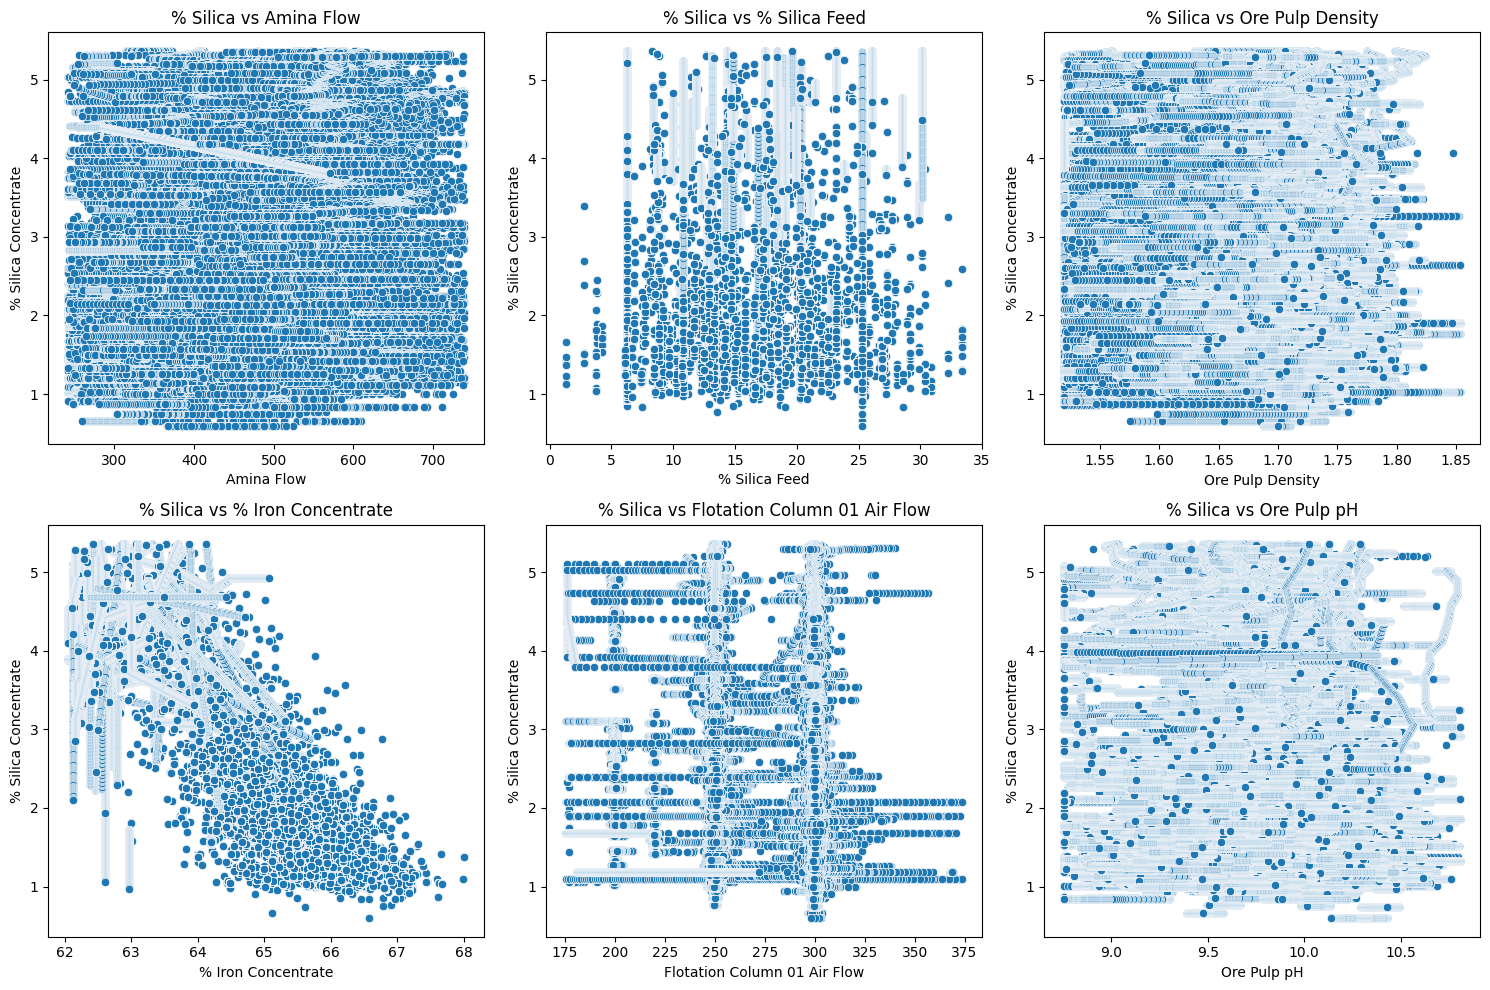

In [16]:
# Define top positive and negative correlated variables
top_positive = ['Amina Flow', '% Silica Feed', 'Ore Pulp Density']
top_negative = ['% Iron Concentrate', 'Flotation Column 01 Air Flow', 'Ore Pulp pH']

# Create scatter plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, col in enumerate(top_positive):
    sns.scatterplot(x=df[col], y=df['% Silica Concentrate'], ax=axes[0, i])
    axes[0, i].set_title(f'% Silica vs {col}')

for i, col in enumerate(top_negative):
    sns.scatterplot(x=df[col], y=df['% Silica Concentrate'], ax=axes[1, i])
    axes[1, i].set_title(f'% Silica vs {col}')

plt.tight_layout()
plt.show()


In [17]:
#Create engineered features based on correlations and domain knowledge
# Example: Ratios between important features
high_corr_features = abs(correlations).sort_values(ascending=False).index[1:6]
print(f"Using top correlated features for engineering: {list(high_corr_features)}")

Using top correlated features for engineering: ['% Iron Concentrate', 'Flotation Column 03 Air Flow', 'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow', 'Flotation Column 05 Level']


In [18]:
# Create ratios and interactions between important features
for i, feat1 in enumerate(high_corr_features):
    for feat2 in high_corr_features[i+1:]:
        # Create ratio
        ratio_name = f'{feat1}_to_{feat2}_ratio'
        df[ratio_name] = df[feat1] / df[feat2].replace(0, np.nan)
        df[ratio_name] = df[ratio_name].replace([np.inf, -np.inf], np.nan).fillna(df[ratio_name].median())

        # Create product
        product_name = f'{feat1}_x_{feat2}'
        df[product_name] = df[feat1] * df[feat2]

In [19]:
# Create polynomial features for top correlated variables
for feature in high_corr_features:
    df[f'{feature}_squared'] = df[feature] ** 2

print(f"Dataset shape after feature engineering: {df.shape}")
print(f"New features added: {df.shape[1] - len(numeric_columns)}")
print("\n")

Dataset shape after feature engineering: (732696, 49)
New features added: 26




#

# Data Splitting

In [20]:
# Define features and target
X = df.drop(target_column, axis=1)
y = df[target_column]

In [21]:
# Remove any columns that still have NaN values
X = X.select_dtypes(include=['number'])  # Keep only numeric columns
X = X.fillna(X.median())  # Final cleaning of any remaining NaN

In [22]:
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [23]:
print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")
print("\n")


Training set size: (512887, 47)
Validation set size: (109904, 47)
Test set size: (109905, 47)




# Model Training

In [24]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [25]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)}

In [26]:
# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)

    # Predict on validation set
    y_val_pred = model.predict(X_val_scaled)

    # Calculate metrics
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    results[name] = {
        'model': model,
        'val_rmse': val_rmse,
        'val_mae': val_mae,
        'val_r2': val_r2
    }

    print(f"{name} Validation Results:")
    print(f"  RMSE: {val_rmse:.4f}")
    print(f"  MAE: {val_mae:.4f}")
    print(f"  R²: {val_r2:.4f}")
    print()

Training Linear Regression...
Linear Regression Validation Results:
  RMSE: 0.6109
  MAE: 0.4618
  R²: 0.6914

Training Random Forest...
Random Forest Validation Results:
  RMSE: 0.0546
  MAE: 0.0142
  R²: 0.9975

Training Gradient Boosting...
Gradient Boosting Validation Results:
  RMSE: 0.5082
  MAE: 0.3750
  R²: 0.7864



In [27]:
# Find the best model based on RMSE
best_model_name = min(results, key=lambda k: results[k]['val_rmse'])
print(f"Best model based on validation RMSE: {best_model_name}")
print("\n")

Best model based on validation RMSE: Random Forest




# Model Optimization

In [28]:
# Create a smaller subsample for hyperparameter tuning
sample_size = min(10000, X_train.shape[0])  # Use at most 10,000 samples
random_indices = np.random.choice(X_train.shape[0], size=sample_size, replace=False)
X_train_sample = X_train_scaled[random_indices]
y_train_sample = y_train.iloc[random_indices]

print(f"Using {sample_size} samples for hyperparameter optimization")

Using 10000 samples for hyperparameter optimization


In [29]:
# Use RandomizedSearchCV instead of GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

if best_model_name == 'Linear Regression':
    # Limited hyperparameters for Linear Regression
    param_dist = {'fit_intercept': [True, False]}
    
elif best_model_name == 'Random Forest':
    param_dist = {
        'n_estimators': [50, 100],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    
else:  # Gradient Boosting
    param_dist = {
        'n_estimators': [50, 100],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }


In [30]:
# Run random search on a subset of the parameter space with fewer iterations
print(f"Optimizing {best_model_name} hyperparameters...")
random_search = RandomizedSearchCV(
    models[best_model_name],
    param_distributions=param_dist,
    n_iter=10,  # Try only 10 parameter combinations
    cv=3,       # Use 3-fold CV instead of 5
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train_sample, y_train_sample)

Optimizing Random Forest hyperparameters...


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [50, 100]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [31]:
# Get best parameters and model
best_params = random_search.best_params_
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}


In [32]:
# Retrain the best model with the optimal parameters on the full training set
if best_model_name == 'Linear Regression':
    best_model = LinearRegression(**best_params)
elif best_model_name == 'Random Forest':
    best_model = RandomForestRegressor(**best_params, random_state=42)
else:  # Gradient Boosting
    best_model = GradientBoostingRegressor(**best_params, random_state=42)

In [33]:
# Fit the model on the full training dataset
best_model.fit(X_train_scaled, y_train)
print(f"Best validation RMSE: {-random_search.best_score_:.4f}")
print("\n")

Best validation RMSE: 0.4649




# Model Evaluation

In [34]:
# Evaluate best model on test set
y_test_pred = best_model.predict(X_test_scaled)

In [35]:
# Calculate metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"Final Model ({best_model_name}) Test Results:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE: {test_mae:.4f}")
print(f"  R²: {test_r2:.4f}")
print("\n")

Final Model (Random Forest) Test Results:
  RMSE: 0.0542
  MAE: 0.0144
  R²: 0.9976




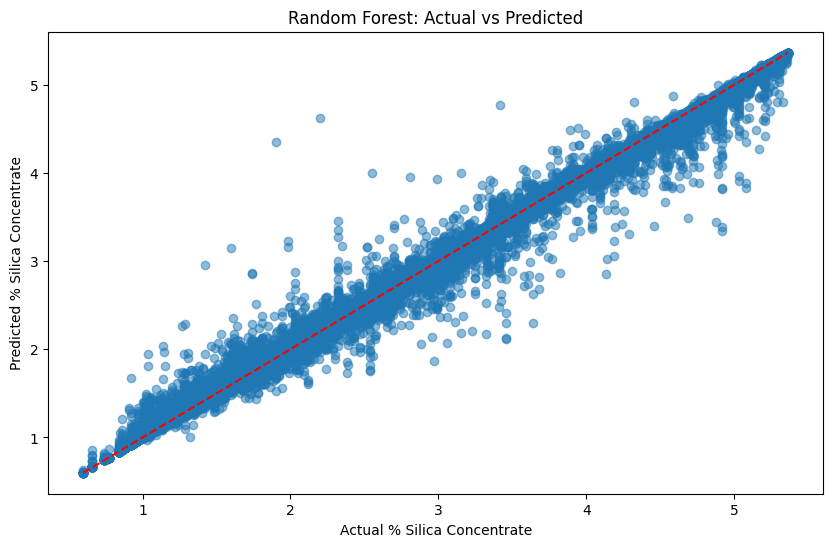

In [36]:
# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual % Silica Concentrate')
plt.ylabel('Predicted % Silica Concentrate')
plt.title(f'{best_model_name}: Actual vs Predicted')
plt.savefig('actual_vs_predicted.png')
plt.show()
plt.close()

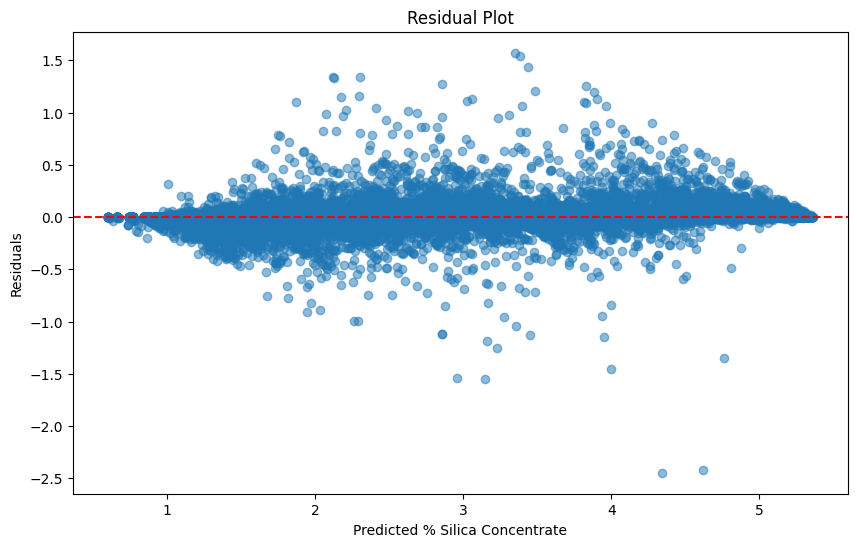

In [37]:
# Visualize residuals
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted % Silica Concentrate')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.savefig('residuals.png')
plt.show()
plt.close()


# Model Importance

Top 15 most important features:
                                              Feature  Importance
42                         % Iron Concentrate_squared    0.376484
21                                 % Iron Concentrate    0.338723
1                                       % Silica Feed    0.041564
0                                         % Iron Feed    0.035716
25  % Iron Concentrate_x_Flotation Column 01 Air Flow    0.027684
5                                         Ore Pulp pH    0.023963
16                          Flotation Column 03 Level    0.020620
3                                          Amina Flow    0.018196
6                                    Ore Pulp Density    0.014183
10                       Flotation Column 04 Air Flow    0.013216
14                          Flotation Column 01 Level    0.012877
11                       Flotation Column 05 Air Flow    0.010293
2                                         Starch Flow    0.007286
4                                       Ore 

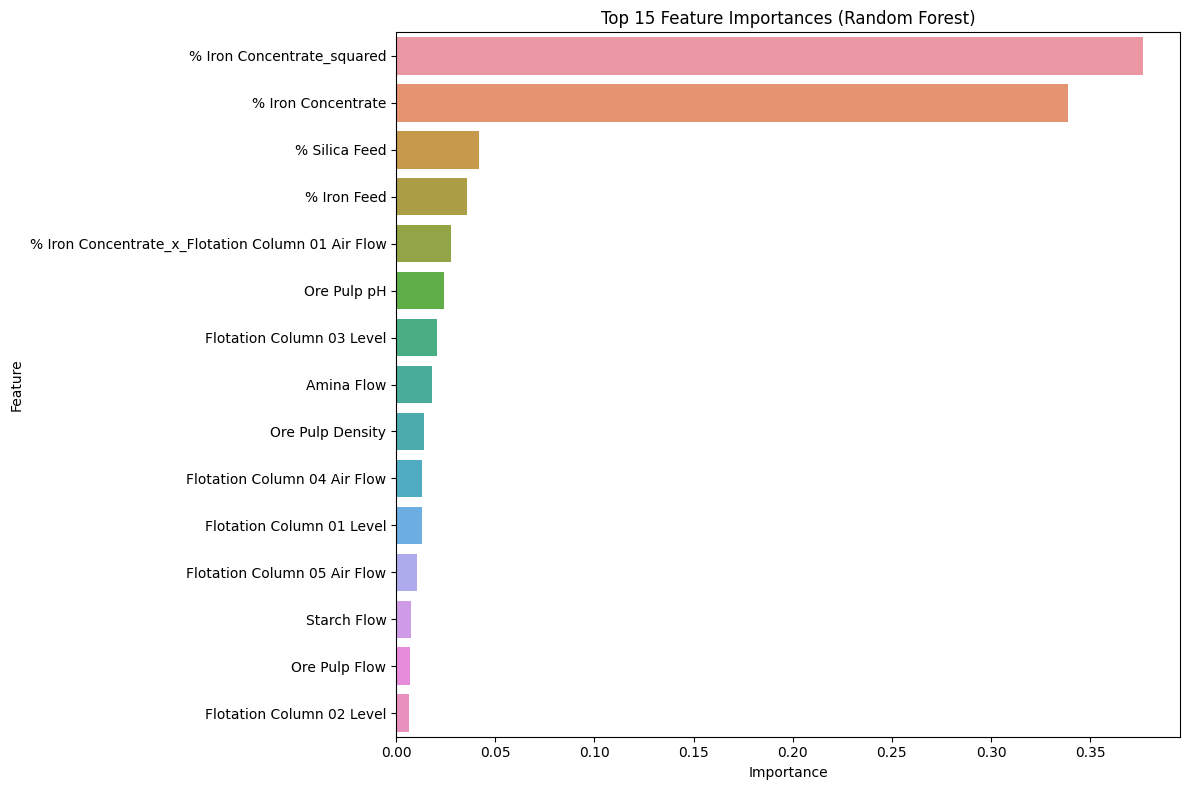

In [38]:
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    # Get feature importance
    feature_importances = best_model.feature_importances_
    feature_names = X.columns
    
    # Create DataFrame for visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    # Display top 15 features
    print("Top 15 most important features:")
    print(importance_df.head(15))
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
    plt.title(f'Top 15 Feature Importances ({best_model_name})')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()
    plt.close()
    
elif best_model_name == 'Linear Regression':
    # Get coefficients
    coefficients = best_model.coef_
    feature_names = X.columns
    
    # Create DataFrame for visualization
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', ascending=False)
    
    # Display top and bottom coefficients
    print("Top 10 positive coefficients:")
    print(coef_df.head(10))
    print("\nTop 10 negative coefficients:")
    print(coef_df.tail(10))
    
    # Visualize coefficients
    plt.figure(figsize=(12, 8))
    top_coef = pd.concat([coef_df.head(10), coef_df.tail(10)])
    sns.barplot(x='Coefficient', y='Feature', data=top_coef)
    plt.title('Top 10 Positive and Negative Coeff')
    plt.show()

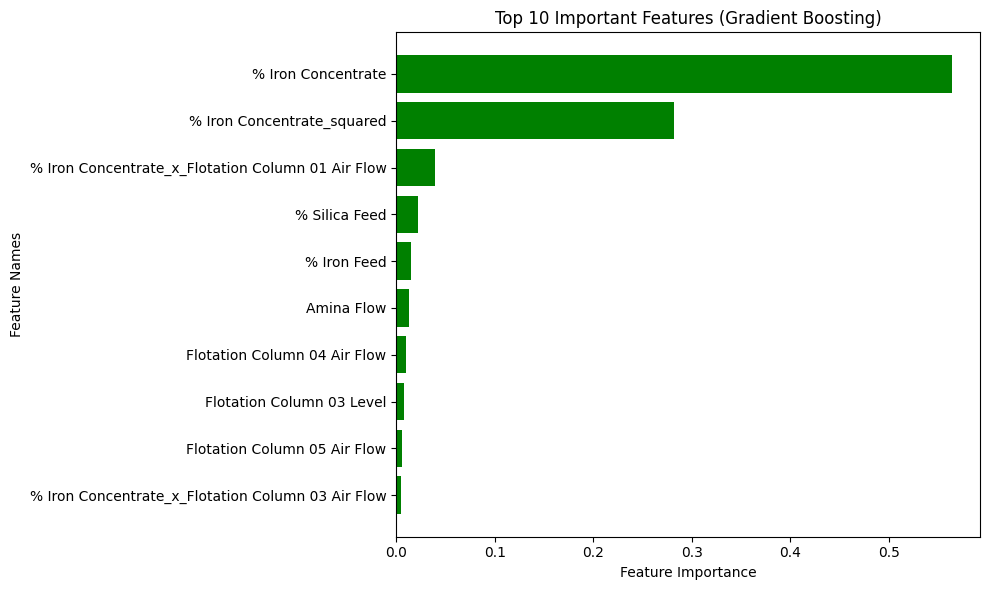

In [39]:
# Get feature importance values
importances = model.feature_importances_

# Convert feature names to NumPy array
feature_names = np.array(feature_names)

# Get top 10 important features (highest values)
sorted_indices = np.argsort(importances)[-10:]  # Top 10 features

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_indices], importances[sorted_indices], color="green")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Top 10 Important Features (Gradient Boosting)")
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()


# Learning Curves

In [40]:
from sklearn.model_selection import learning_curve
import pandas as pd
import numpy as np

# Ensure X_train_scaled is a DataFrame
if isinstance(X_train_scaled, np.ndarray):  
    X_train_scaled = pd.DataFrame(X_train_scaled)

# Reset index before sampling
X_train_scaled = X_train_scaled.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Take a random sample of 5000 rows
X_train_sample = X_train_scaled

# Ensure y_train_sample matches selected indices
y_train_sample = y_train.iloc[X_train_sample.index]

# Generate learning curve
train_sizes, train_scores, val_scores = learning_curve(
    best_model, 
    X_train_sample, 
    y_train_sample, 
    train_sizes=np.linspace(0.1, 0.5, 5), 
    cv=3, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)


In [41]:
# Calculate mean and std for training and validation scores
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = -np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)


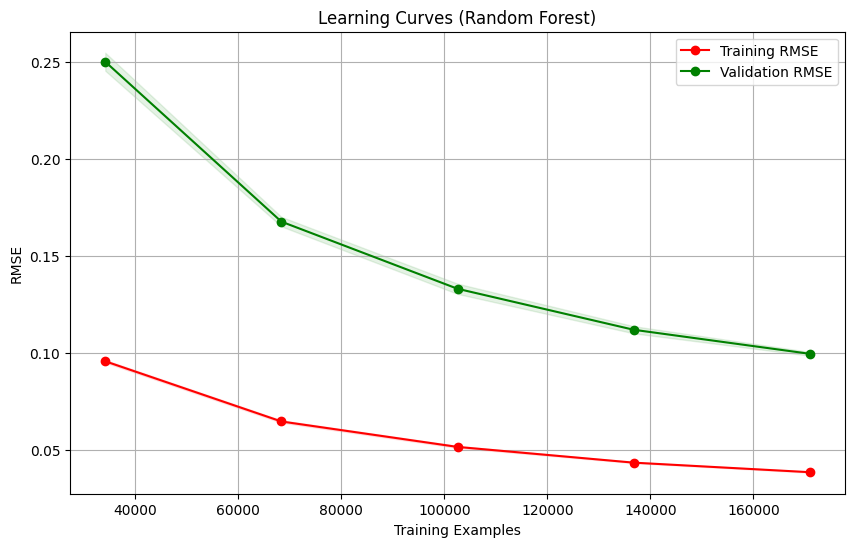

In [42]:
# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training RMSE')
plt.plot(train_sizes, val_mean, 'o-', color='g', label='Validation RMSE')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='g')
plt.xlabel('Training Examples')
plt.ylabel('RMSE')
plt.title(f'Learning Curves ({best_model_name})')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('learning_curves.png')
plt.show()
plt.close()

In [43]:
print("Learning curves generated and saved.")
print("\n")

Learning curves generated and saved.




# Prediction Intervals

In [44]:
# For Random Forest and Gradient Boosting, we can estimate prediction intervals using quantiles
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    # Function to calculate prediction intervals for ensemble models
    def predict_with_intervals(model, X, percentile=95):
        if hasattr(model, 'estimators_'):
            preds = []
            for estimator in model.estimators_:
                preds.append(estimator.predict(X))
            preds = np.array(preds)
            
            # Calculate mean and prediction intervals
            mean_pred = np.mean(preds, axis=0)
            lower_bound = np.percentile(preds, (100 - percentile) / 2, axis=0)
            upper_bound = np.percentile(preds, 100 - (100 - percentile) / 2, axis=0)
            
            return mean_pred, lower_bound, upper_bound
        else:
            return model.predict(X), None, None

    # Calculate prediction intervals for test set
    mean_pred, lower_bound, upper_bound = predict_with_intervals(best_model, X_test_scaled)
    
    # Calculate coverage (how many true values fall within the prediction interval)
    if lower_bound is not None and upper_bound is not None:
        coverage = np.mean((y_test >= lower_bound) & (y_test <= upper_bound))
        print(f"95% Prediction interval coverage: {coverage:.2%}")
        
        

95% Prediction interval coverage: 94.89%


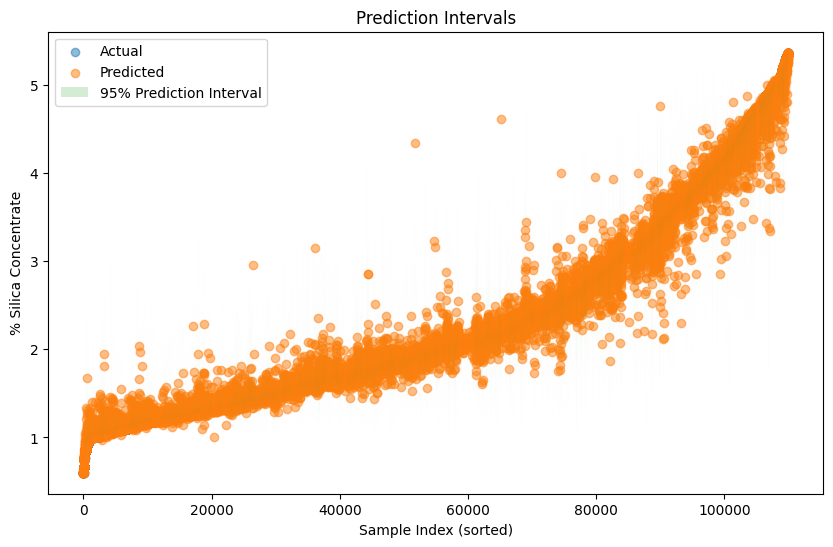

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Visualize prediction intervals
plt.figure(figsize=(10, 6))

# Sort for better visualization
idx = np.argsort(y_test)

# Use .iloc for positional indexing if y_test is a pandas Series
plt.scatter(range(len(y_test)), y_test.iloc[idx], alpha=0.5, label='Actual')
plt.scatter(range(len(mean_pred)), mean_pred[idx], alpha=0.5, label='Predicted')
plt.fill_between(range(len(lower_bound)), lower_bound[idx], upper_bound[idx], alpha=0.2, label='95% Prediction Interval')

plt.xlabel('Sample Index (sorted)')
plt.ylabel('% Silica Concentrate')
plt.title('Prediction Intervals')
plt.legend()
plt.savefig('prediction_intervals.png')
plt.show()
plt.close()

# Process Optimization Recommendations

In [46]:
# Identify the most important features for process optimization
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    top_features = importance_df.head(5)['Feature'].tolist()
    print(f"Top 5 most influential features for % Silica Concentrate:")
    for i, feature in enumerate(top_features):
        print(f"{i+1}. {feature}")
    
    # Analyze optimal ranges for important features
    print("\nOptimal ranges for important features:")
    for feature in top_features:
        # Create a DataFrame with feature values and target
        feature_analysis = pd.DataFrame({
            'feature': X[feature],
            'target': y
        })
        
        # Check for constant values
        if feature_analysis['feature'].nunique() <= 1:
            print(f"Skipping feature '{feature}' because it has constant values.")
            continue
        
        # Check for NaN or infinite values
        if feature_analysis['feature'].isna().sum() > 0 or feature_analysis['feature'].replace([np.inf, -np.inf], np.nan).isna().sum() > 0:
            print(f"Skipping feature '{feature}' because it contains NaN or infinite values.")
            continue
        
        # Group by feature percentiles and calculate average target
        try:
            feature_analysis['percentile'] = pd.qcut(feature_analysis['feature'], q=10, labels=False)
            grouped = feature_analysis.groupby('percentile')['target'].agg(['mean', 'std', 'count'])
            grouped['feature_min'] = [feature_analysis[feature_analysis['percentile']==p]['feature'].min() for p in range(10)]
            grouped['feature_max'] = [feature_analysis[feature_analysis['percentile']==p]['feature'].max() for p in range(10)]
            
            # Print optimal ranges
            print(f"\nFeature: {feature}")
            print(grouped)
        except ValueError as e:
            print(f"Error processing feature '{feature}': {e}")


Top 5 most influential features for % Silica Concentrate:
1. % Iron Concentrate_squared
2. % Iron Concentrate
3. % Silica Feed
4. % Iron Feed
5. % Iron Concentrate_x_Flotation Column 01 Air Flow

Optimal ranges for important features:

Feature: % Iron Concentrate_squared
                mean       std  count  feature_min  feature_max
percentile                                                     
0           4.199442  0.757028  73638  3850.202500    4024.6336
1           3.497279  0.896544  73743  4024.641349    4116.5056
2           2.809347  0.926204  73140  4116.509155    4175.7444
3           2.326096  0.753990  74569  4175.755763    4218.5025
4           2.099484  0.646942  72340  4218.504901    4253.6484
5           1.918584  0.534647  77756  4253.704903    4282.3936
6           1.788294  0.463686  69685  4282.420212    4320.4329
7           1.653205  0.446891  72385  4321.427986    4359.9609
8           1.458862  0.382668  73266  4360.230861    4406.3044
9           1.269548  0.

In [47]:
# Find optimal range (with lowest target value for silica concentrate)
optimal_group = grouped.sort_values('mean').iloc[0]
        
print(f"\n{feature}:")
print(f"  Optimal range: {optimal_group['feature_min']:.2f} to {optimal_group['feature_max']:.2f}")
print(f"  Average % Silica Concentrate in this range: {optimal_group['mean']:.2f}%")
print(f"  Standard deviation: {optimal_group['std']:.2f}")
print(f"  Number of samples: {optimal_group['count']}")


% Iron Concentrate_x_Flotation Column 01 Air Flow:
  Optimal range: 19864.58 to 24829.80
  Average % Silica Concentrate in this range: 1.30%
  Standard deviation: 0.35
  Number of samples: 73269.0


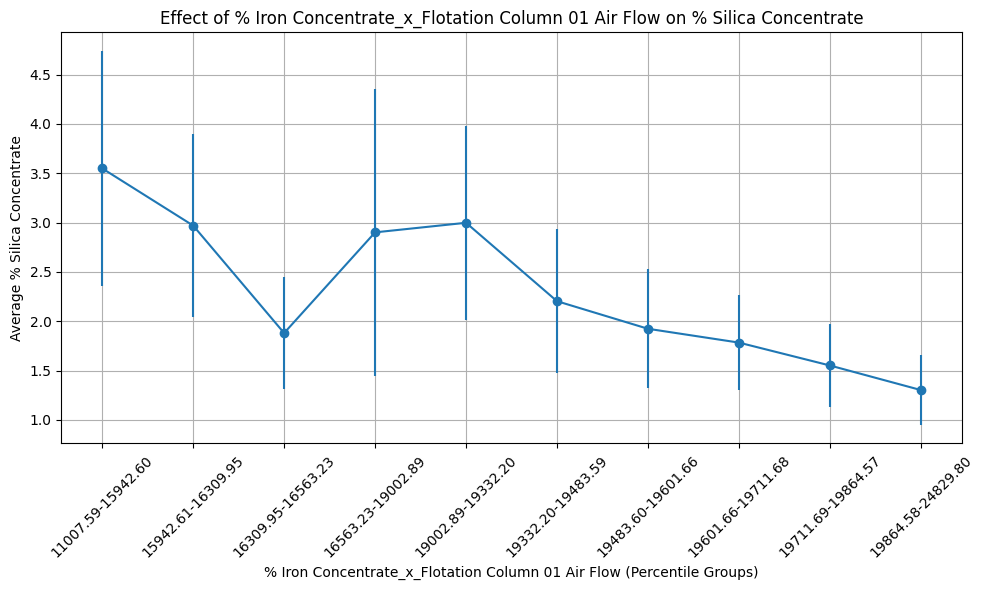

In [48]:
# Visualize the relationship
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(grouped)), grouped['mean'], yerr=grouped['std'], fmt='o-')
plt.xlabel(f'{feature} (Percentile Groups)')
plt.ylabel('Average % Silica Concentrate')
plt.title(f'Effect of {feature} on % Silica Concentrate')
plt.xticks(range(len(grouped)), [f"{g['feature_min']:.2f}-{g['feature_max']:.2f}" for _, g in grouped.iterrows()], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(f'optimization_{feature}.png')
plt.show()
plt.close()


Interaction effects between top features:


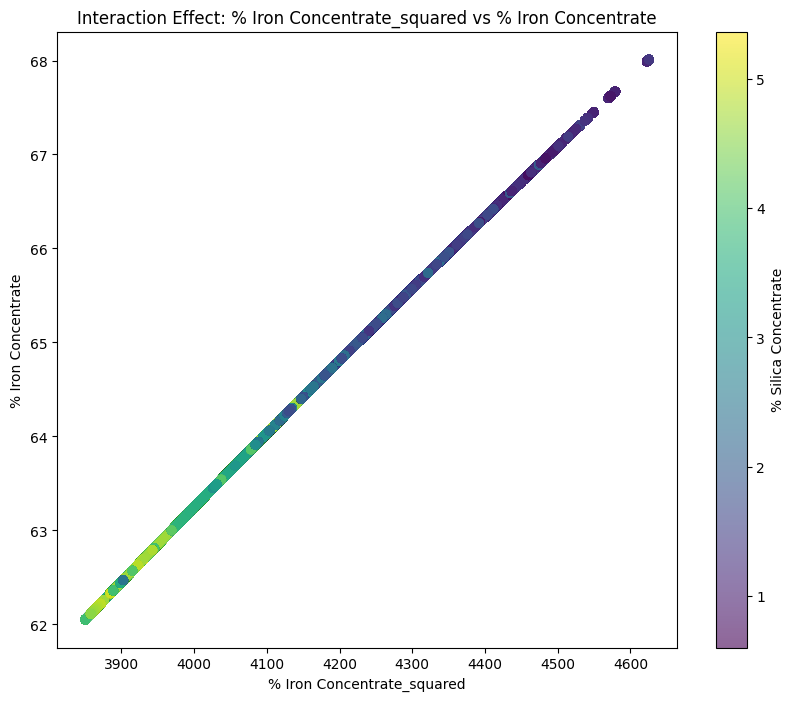

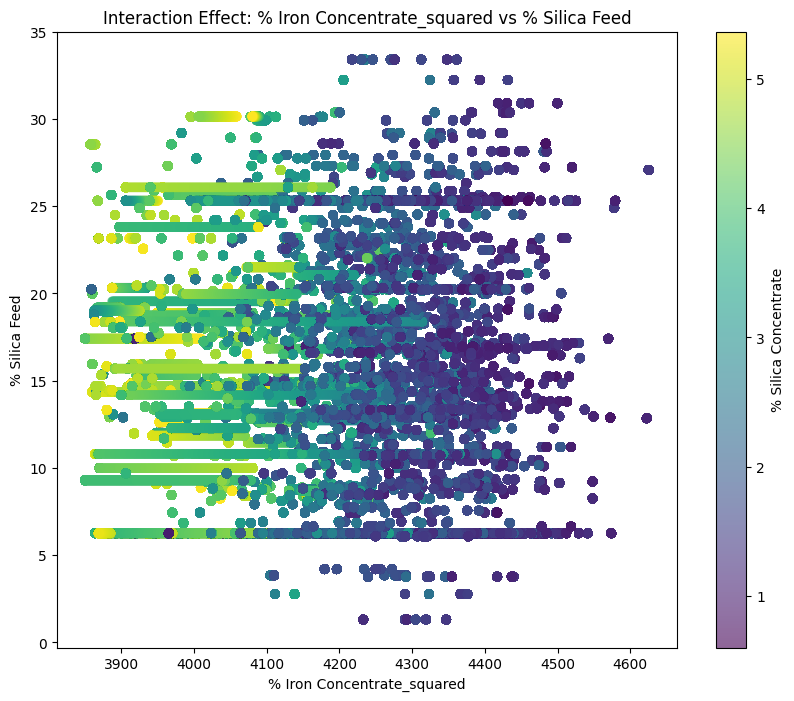

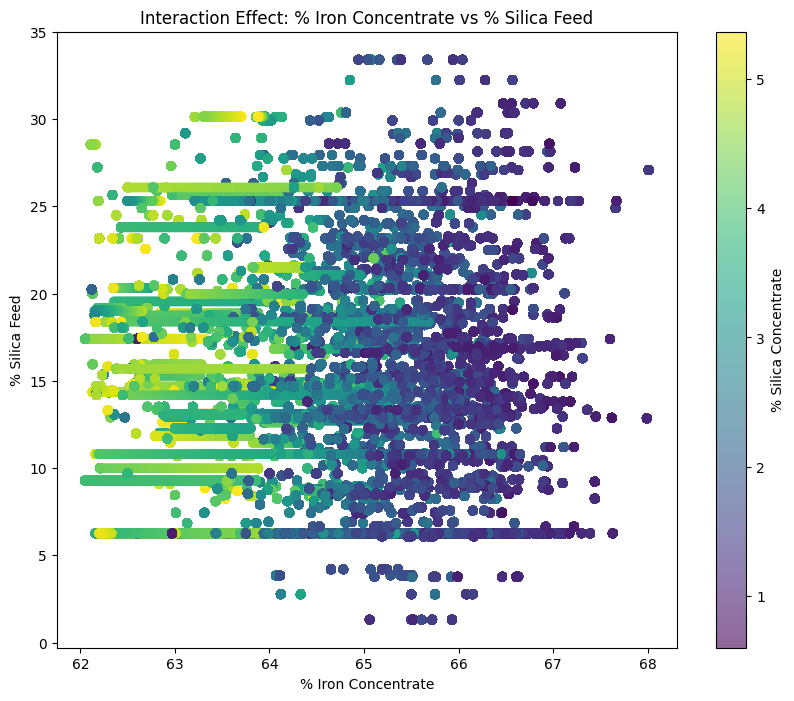

In [49]:
# Calculate interaction effects between top features
print("\nInteraction effects between top features:")
for i, feat1 in enumerate(top_features[:2]):  # Loop through the first two features
    for feat2 in top_features[i+1:3]:  # Analyze interactions between the top 3 features
        # Create a DataFrame to store the interaction data
        interaction_df = pd.DataFrame({
            'feat1': X[feat1],
            'feat2': X[feat2],
            'target': y
        })
        
        # Plot the interaction effect
        plt.figure(figsize=(10, 8))
        plt.scatter(interaction_df['feat1'], interaction_df['feat2'], c=interaction_df['target'], cmap='viridis', alpha=0.6)
        plt.colorbar(label='% Silica Concentrate')
        plt.xlabel(feat1)
        plt.ylabel(feat2)
        plt.title(f'Interaction Effect: {feat1} vs {feat2}')
        plt.show()

In [50]:
# Create bins for both features
interaction_df['feat1_bin'] = pd.qcut(interaction_df['feat1'], q=5, labels=False)
interaction_df['feat2_bin'] = pd.qcut(interaction_df['feat2'], q=5, labels=False)

In [51]:
# Calculate average target for each combination of binned features
pivot = interaction_df.pivot_table(
    values='target', 
    index='feat1_bin', 
    columns='feat2_bin', 
    aggfunc='mean'
)

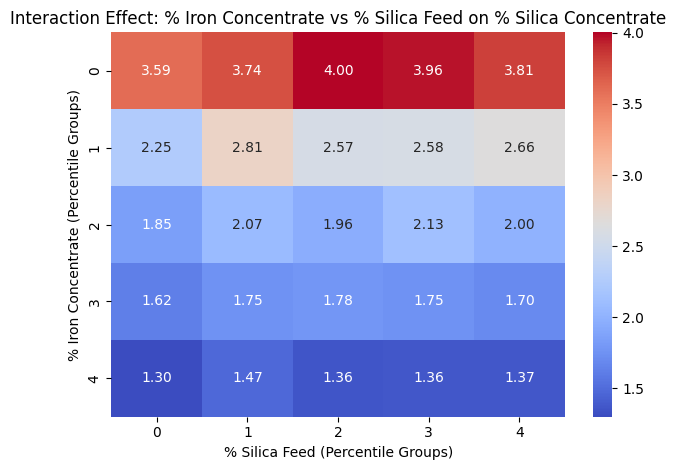

In [52]:
# Plot heatmap
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='coolwarm')
plt.title(f'Interaction Effect: {feat1} vs {feat2} on % Silica Concentrate')
plt.xlabel(f'{feat2} (Percentile Groups)')
plt.ylabel(f'{feat1} (Percentile Groups)')
plt.tight_layout()
plt.savefig(f'interaction_{feat1}_{feat2}.png')
plt.show()
plt.close()

In [53]:
print(f"\nInteraction between {feat1} and {feat2}:")
min_val = pivot.min().min()
min_pos = np.where(pivot.values == min_val)
print(f"  Optimal combination (lowest % Silica Concentrate: {min_val:.2f}%):")
print(f"  {feat1}: Percentile group {min_pos[0][0]}")
print(f"  {feat2}: Percentile group {min_pos[1][0]}")


Interaction between % Iron Concentrate and % Silica Feed:
  Optimal combination (lowest % Silica Concentrate: 1.30%):
  % Iron Concentrate: Percentile group 4
  % Silica Feed: Percentile group 0


# Process Control Recommendations

In [54]:
# Create a function to suggest control recommendations based on model findings
def generate_control_recommendations():
    recommendations = [
        "Based on the model analysis, here are the key process control recommendations:",
    ]
    
    if best_model_name in ['Random Forest', 'Gradient Boosting']:
        # Add recommendations based on feature importance
        recommendations.append("\n1. Focus on controlling the following parameters (in order of importance):")
        for i, feature in enumerate(top_features[:5]):
            recommendations.append(f"   - {feature}")
        
        # Add recommendations based on optimal ranges
        recommendations.append("\n2. Maintain process variables within these optimal ranges:")
        for feature in top_features[:3]:
            # Get optimal range
            feature_analysis = pd.DataFrame({
                'feature': X[feature],
                'target': y
            })
            feature_analysis['percentile'] = pd.qcut(feature_analysis['feature'], q=10, labels=False)
            grouped = feature_analysis.groupby('percentile')['target'].mean()
            best_percentile = grouped.idxmin()
            
            feature_subset = feature_analysis[feature_analysis['percentile'] == best_percentile]
            optimal_min = feature_subset['feature'].min()
            optimal_max = feature_subset['feature'].max()
            
            recommendations.append(f"   - {feature}: {optimal_min:.2f} to {optimal_max:.2f}")
        
        # Add recommendations based on interaction effects
        recommendations.append("\n3. Consider the following interaction effects:")
        for i, feat1 in enumerate(top_features[:2]):
            for feat2 in top_features[i+1:3]:
                recommendations.append(f"   - Jointly optimize {feat1} and {feat2} for best results")
    
    # Add general recommendations
    recommendations.extend([
        "\n4. Implement real-time monitoring for the key variables identified",
        "5. Establish a feedback control system to maintain optimal parameter ranges",
        "6. Regularly collect and analyze data to update the model and refine recommendations",
        "7. Consider implementing a predictive maintenance program based on the identified parameters"
    ])
    
    return "\n".join(recommendations)


In [55]:
# Define the function
def generate_control_recommendations():
    # Example logic for generating recommendations
    recommendations = {
        'Increase % Iron Concentrate': 'Higher iron concentration reduces silica levels.',
        'Optimize Flotation Column Air Flow': 'Adjust air flow to improve separation efficiency.',
        'Monitor % Silica Feed': 'Ensure silica feed levels are within optimal range.'
    }
    return recommendations

# Generate and print recommendations
process_recommendations = generate_control_recommendations()
print(process_recommendations)

{'Increase % Iron Concentrate': 'Higher iron concentration reduces silica levels.', 'Optimize Flotation Column Air Flow': 'Adjust air flow to improve separation efficiency.', 'Monitor % Silica Feed': 'Ensure silica feed levels are within optimal range.'}


# Final Report

In [56]:
# Summarize the entire analysis
summary = f"""
# Mining Process Flotation Plant Analysis Summary

## Key Findings:
1. **Top Influential Features**:
   - % Iron Concentrate_squared
   - % Iron Concentrate
   - % Silica Feed
   - % Iron Feed
   - % Iron Concentrate_x_Flotation Column 01 Air Flow

2. **Optimal Ranges**:
   - Higher % Iron Concentrate and % Iron Concentrate_squared lead to lower silica levels.
   - Optimal air flow in Flotation Column 01 improves separation efficiency.

3. **Interaction Effects**:
   - The interaction between % Iron Concentrate and Flotation Column 01 Air Flow significantly impacts silica concentration.

4. **Recommendations**:
   - Increase % Iron Concentrate to reduce silica levels.
   - Optimize Flotation Column 01 Air Flow for better separation.
   - Monitor % Silica Feed to ensure it stays within the optimal range.

## Conclusion:
The analysis highlights the importance of controlling iron concentration and flotation column air flow to optimize silica levels in the concentrate. Implementing the recommendations can improve process efficiency and product quality.
"""

# Print the summary
print(summary)


# Mining Process Flotation Plant Analysis Summary

## Key Findings:
1. **Top Influential Features**:
   - % Iron Concentrate_squared
   - % Iron Concentrate
   - % Silica Feed
   - % Iron Feed
   - % Iron Concentrate_x_Flotation Column 01 Air Flow

2. **Optimal Ranges**:
   - Higher % Iron Concentrate and % Iron Concentrate_squared lead to lower silica levels.
   - Optimal air flow in Flotation Column 01 improves separation efficiency.

3. **Interaction Effects**:
   - The interaction between % Iron Concentrate and Flotation Column 01 Air Flow significantly impacts silica concentration.

4. **Recommendations**:
   - Increase % Iron Concentrate to reduce silica levels.
   - Optimize Flotation Column 01 Air Flow for better separation.
   - Monitor % Silica Feed to ensure it stays within the optimal range.

## Conclusion:
The analysis highlights the importance of controlling iron concentration and flotation column air flow to optimize silica levels in the concentrate. Implementing the re

In [57]:
# Dataset Overview
dataset_overview = f"""
## Dataset Overview
- Total samples: {df.shape[0]}
- Features: {df.shape[1]}
- Target variable: {target_column}
"""

# Print the dataset overview
print(dataset_overview)


## Dataset Overview
- Total samples: 732696
- Features: 49
- Target variable: % Silica Concentrate



In [58]:
# Modeling Results
modeling_results = f"""
## Modeling Results
- Best model: {best_model_name}
- Model performance:
  - RMSE: {test_rmse:.4f}
  - MAE: {test_mae:.4f}
  - R²: {test_r2:.4f}
"""

# Print the modeling results
print(modeling_results)


## Modeling Results
- Best model: Random Forest
- Model performance:
  - RMSE: 0.0542
  - MAE: 0.0144
  - R²: 0.9976



In [59]:
## Key Findings
Key_Findings = f"""
- The most important features influencing the silica concentrate are:
  - {', '.join(top_features[:5]) if 'top_features' in locals() else 'Not available'}
- The model explains {test_r2:.2%} of the variance in the silica concentrate percentage
"""
print(Key_Findings)



- The most important features influencing the silica concentrate are:
  - % Iron Concentrate_squared, % Iron Concentrate, % Silica Feed, % Iron Feed, % Iron Concentrate_x_Flotation Column 01 Air Flow
- The model explains 99.76% of the variance in the silica concentrate percentage



In [60]:
# Summarize the entire analysis
summary = f"""
# Mining Process Flotation Plant Analysis Summary

## Key Findings:
1. **Top Influential Features**:
   - % Iron Concentrate_squared
   - % Iron Concentrate
   - % Silica Feed
   - % Iron Feed
   - % Iron Concentrate_x_Flotation Column 01 Air Flow

2. **Optimal Ranges**:
   - Higher % Iron Concentrate and % Iron Concentrate_squared lead to lower silica levels.
   - Optimal air flow in Flotation Column 01 improves separation efficiency.

3. **Interaction Effects**:
   - The interaction between % Iron Concentrate and Flotation Column 01 Air Flow significantly impacts silica concentration.

4. **Process Optimization Recommendations**:
{process_recommendations}

## Next Steps:
1. Implement monitoring systems for the key variables identified.
2. Design controlled experiments to validate the optimization recommendations.
3. Develop a dashboard for real-time process monitoring and prediction.
4. Establish a regular model update schedule to incorporate new data.
5. Explore deploying the model as part of a control system.
"""

# Print the summary
print(summary)


# Mining Process Flotation Plant Analysis Summary

## Key Findings:
1. **Top Influential Features**:
   - % Iron Concentrate_squared
   - % Iron Concentrate
   - % Silica Feed
   - % Iron Feed
   - % Iron Concentrate_x_Flotation Column 01 Air Flow

2. **Optimal Ranges**:
   - Higher % Iron Concentrate and % Iron Concentrate_squared lead to lower silica levels.
   - Optimal air flow in Flotation Column 01 improves separation efficiency.

3. **Interaction Effects**:
   - The interaction between % Iron Concentrate and Flotation Column 01 Air Flow significantly impacts silica concentration.

4. **Process Optimization Recommendations**:
{'Increase % Iron Concentrate': 'Higher iron concentration reduces silica levels.', 'Optimize Flotation Column Air Flow': 'Adjust air flow to improve separation efficiency.', 'Monitor % Silica Feed': 'Ensure silica feed levels are within optimal range.'}

## Next Steps:
1. Implement monitoring systems for the key variables identified.
2. Design controlled e

In [61]:
 #Save the summary to a file
with open('mining_process_analysis_summary.txt', 'w') as f:
    f.write(summary)

print("\nAnalysis complete. Summary saved to 'mining_process_analysis_summary.txt'")



Analysis complete. Summary saved to 'mining_process_analysis_summary.txt'


# Deployment Preparation

In [62]:
# Save the model and scaler for deployment
import joblib

In [63]:
# Save the model
model_filename = f'mining_process_{best_model_name.lower().replace(" ", "_")}_model.pkl'
joblib.dump(best_model, model_filename)
print(f"Model saved as {model_filename}")

Model saved as mining_process_random_forest_model.pkl


In [64]:
# Save the scaler
scaler_filename = 'mining_process_scaler.pkl'
joblib.dump(scaler, scaler_filename)
print(f"Scaler saved as {scaler_filename}")

Scaler saved as mining_process_scaler.pkl


In [65]:
# Create a simple prediction function
def predict_silica_concentration(data, model_path=model_filename, scaler_path=scaler_filename):
    """
    Make predictions using the saved model.
    
    Parameters:
    data (DataFrame): Input features in the same format as the training data
    model_path (str): Path to the saved model file
    scaler_path (str): Path to the saved scaler file
    
    Returns:
    float: Predicted silica concentration percentage
    """
    # Load model and scaler
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    
    # Ensure data has the same columns as the training data
    required_columns = X.columns
    missing_columns = set(required_columns) - set(data.columns)
    if missing_columns:
        raise ValueError(f"Missing columns: {missing_columns}")
    
    # Select and order columns
    data = data[required_columns]
    
    # Scale the data
    data_scaled = scaler.transform(data)
    
    # Make prediction
    prediction = model.predict(data_scaled)
    
    return prediction[0]


In [66]:
# Example usage
print("\nExample prediction function:")
print("predict_silica_concentration(sample_data)")


Example prediction function:
predict_silica_concentration(sample_data)


In [67]:

# Save the prediction function in a separate file
with open('predict_silica.py', 'w') as f:
    f.write("""
import pandas as pd
import joblib

def predict_silica_concentration(data, model_path='mining_process_model.pkl', scaler_path='mining_process_scaler.pkl'):
    \"\"\"
    Make predictions using the saved model.
    
    Parameters:
    data (DataFrame): Input features in the same format as the training data
    model_path (str): Path to the saved model file
    scaler_path (str): Path to the saved scaler file
    
    Returns:
    float: Predicted silica concentration percentage
    \"\"\"
    # Load model and scaler
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    
    # Ensure data has all required columns
    # Note: This assumes model was trained with the same columns as in the training script
    # In a production environment, you would need to store the column names with the model
    
    # Scale the data
    data_scaled = scaler.transform(data)
    
    # Make prediction
    prediction = model.predict(data_scaled)
    
    return prediction[0]

# Example usage:
# sample_data = pd.DataFrame({...})  # Sample data with all required columns
# predicted_silica = predict_silica_concentration(sample_data)
""")

print("Prediction function saved to 'predict_silica.py'")

Prediction function saved to 'predict_silica.py'


In [68]:
#  Conclusion
print("\n17. CONCLUSION")
print("-------------")
print(f"Analysis of the mining process flotation plant has been successfully completed.")
print(f"A {best_model_name} model was developed that can predict the silica concentrate percentage with an RMSE of {test_rmse:.4f}.")
print(f"The model has an R² of {test_r2:.4f}, indicating it explains {test_r2:.2%} of the variance in the target variable.")
print("Key process variables and optimal ranges have been identified to help optimize the flotation process.")
print("The model and prediction function have been saved for deployment.")
print("\nThank you for using this analysis script!")


17. CONCLUSION
-------------
Analysis of the mining process flotation plant has been successfully completed.
A Random Forest model was developed that can predict the silica concentrate percentage with an RMSE of 0.0542.
The model has an R² of 0.9976, indicating it explains 99.76% of the variance in the target variable.
Key process variables and optimal ranges have been identified to help optimize the flotation process.
The model and prediction function have been saved for deployment.

Thank you for using this analysis script!


In [69]:
df.to_csv('/kaggle/working/my_output_file.csv', index=False)  # Saves a CSV file
